In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
import torchvision
from tqdm import tqdm_notebook
import torchvision.transforms as transforms
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import pdb

%matplotlib inline

In [56]:
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [57]:
batch_size = 20

In [58]:
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

class_names = tuple(str(i) for i in range(10))

In [59]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

class_names = tuple(str(i) for i in range(10))

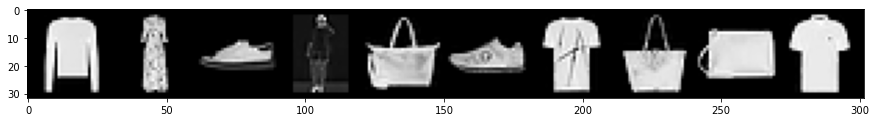

In [60]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
images, labels = dataiter.next()

plt.figure(figsize=(15,10))
imshow(torchvision.utils.make_grid(images[:10], nrow=10))
plt.show()

In [61]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [62]:
device

'cuda'

## Model parameters

In [63]:
device='cpu'

In [64]:
class VAE_MCMC(nn.Module): # TODO: new architecture + HMC + no optimizer
    def __init__(self, hidden_dim):
        super(VAE_MCMC, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.encoder = nn.Sequential(nn.Linear(784,196),
                                     nn.Softplus())
#                                      nn.Linear(392, 196))
#                                      nn.Softplus())
        
        self.hidden_mu = nn.Linear(196, self.hidden_dim)
        self.hidden_log_var = nn.Linear(196, self.hidden_dim)
        
        self.decoder = nn.Sequential(nn.Linear(self.hidden_dim, 196),
                                     nn.Softplus(),
                                     nn.Linear(196, 392),
                                     nn.Softplus(),
                                     nn.Linear(392, 784),
                                     nn.Sigmoid())

    def encode(self, x):
        hidden = self.encoder(x)
        mu = self.hidden_mu(hidden)
        log_var = self.hidden_log_var(hidden)
        return mu, log_var

    def reparametrize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        z = torch.randn_like(std) # get normal distribution size of sigma
        return mu + z*std
    
    def decode(self, z):
        x = self.decoder(z)
        return x
    
    def forward(self, x):
        mu, log_var = self.encode(x.view(-1, 784))
        hidden = self.reparametrize(mu, log_var) # bottleneck
        output = self.decoder(hidden) # x_out
        return mu, log_var, output

In [65]:
def std_normal(mu=None, std=None, dim=784):
    loc = mu if mu!=None else torch.zeros(dim, device=device, requires_grad=False)
    scale = std if std!=None else torch.ones(dim, device=device, requires_grad=False)
    std_normal = torch.distributions.Normal(loc=loc, scale=scale)
    return std_normal

In [66]:
def log_prob_density(x_out, x, dim=784):
    loss = F.binary_cross_entropy(x_out, x.view(-1, dim), reduction='none')
    return loss # vector

In [67]:
def loss_fn(mu, log_var, x_out, x):
    kl_loss = -0.5 * torch.sum( 1 + log_var - mu**2 - torch.exp(log_var))
    recon_loss = F.binary_cross_entropy(x_out, x.view(-1, 784), reduction='sum')
    loss = recon_loss + kl_loss
    return loss

In [70]:
def HMC(current_z, x, epsilon, L): # U(z) = -logp(z,x)
    current_z.requires_grad_(True)
    z = current_z
    r = torch.randn_like(z)
    current_r = r
    U = torch.sum(log_prob_density(net2.decode(z), x).sum(1) - std_normal(dim=z.shape[1]).log_prob(z).sum(1))
    r = r + 0.5 * epsilon * torch.autograd.grad(U, z)[0]
    for i in range(L):
        z = z + epsilon * r
#         pdb.set_trace()
#         print("===> {}/{} leapfrog".format(i+1, L))
        U = torch.sum(log_prob_density(net2.decode(z), x).sum(1) - std_normal(dim=z.shape[1]).log_prob(z).sum(1))
        if i!=L-1: r = r + epsilon * torch.autograd.grad(U, z)[0]
                                
    current_U = log_prob_density(net2.decode(current_z), x).sum(1) +\
                std_normal(dim=current_z.shape[1]).log_prob(current_z).sum(1)
    current_K = ((current_r**2) / 2).sum(1)

    proposed_U = log_prob_density(net2.decode(z), x).sum(1) +\
                 std_normal(dim=z.shape[1]).log_prob(z).sum(1)
    proposed_K = ((r**2) / 2).sum(1)
    
    # Metropolis
    u = D.uniform.Uniform(0,1).sample((batch_size,))
    zfilter = torch.ones(batch_size,1, device=device, requires_grad=False)
    for i in range(batch_size):
        if u[i] > torch.exp(current_U-proposed_U+current_K-proposed_K)[i]:
            zfilter[i] = 0.0
    result = zfilter * z.detach() + (1-zfilter) * current_z.detach()
    return result

## Train and test

In [71]:
def train(epoch, epsilon):
    torch.autograd.set_detect_anomaly(True)
    net2.train()
    running_loss = 0
#     L = int(torch.linalg.norm(epsilon).item()) # leapfrog steps for HMC
    L = 1
    for batch_idx, (data, _) in enumerate(tqdm_notebook(trainloader)):       
        optimizer.zero_grad()
        mu, log_var, x_out = net2(data)
             
#         epsilon = epsilon * torch.exp(log_var).mean(0)
        z = net2.reparametrize(mu, log_var)

        loss = loss_fn(mu, log_var, x_out, data)
        loss.backward()

        with torch.no_grad():
            for l in [net2.decoder]:#, net2.hidden_mu, net2.hidden_log_var]:
                if hasattr(l, 'weight'):
                    l.weight.grad = None
                    l.bias.grad = None
#             for l in [net2.encoder, net2.hidden_mu, net2.hidden_log_var]:
#                 if hasattr(l, 'weight'):  # optimizer step
#                     l.weight -= l.weight.grad*lr
#                     l.bias -= l.bias.grad*lr
#                     l.weight.grad.zero_()
#                     l.bias.grad.zero_()
        optimizer.step()
        optimizer.zero_grad()
        
        for p in net2.decoder.parameters(): 
            p.requires_grad_(False)
            
        for m in range(M):
#             print("{}/{} HMC iteration".format(m+1,M))
            z = HMC(z, data, epsilon, L)
#             pdb.set_trace()

        for p in net2.decoder.parameters(): 
            p.requires_grad_(True)
        
        loss = loss_fn(mu.detach(), log_var.detach(), net2.decode(z), data)
        loss.backward()
        
        with torch.no_grad():
            for l in [net2.encoder, net2.hidden_mu, net2.hidden_log_var]:
                if hasattr(l, 'weight'):
                    l.weight.grad = None
                    l.bias.grad = None
#             for l in [net2.decoder]:#, net2.hidden_mu, net2.hidden_log_var]:
#                 if hasattr(l, 'weight'):
#                     l.weight -= l.weight.grad*lr
#                     l.bias -= l.bias.grad*lr
#                     l.weight.grad.zero_()
#                     l.bias.grad.zero_()
        optimizer.step()
        optimizer.zero_grad()
        
        running_loss += loss.item()
        if batch_idx % (log_interval*6) == 0: history['train'].append(loss.item()/len(data))
                         
    print("===> Epoch: {}/{} Average train loss: {:.4f}".format(epoch, num_epochs, running_loss/len(trainloader.dataset)))
    
def test(epoch):
    net2.eval()
    running_loss = 0
    for batch_idx, (data, _) in enumerate(testloader):
        with torch.no_grad():
            mu, log_var, x_out = net2(data)
            loss = loss_fn(mu, log_var, x_out, data)
            running_loss += loss.item()
            if batch_idx % log_interval == 0:
                history['test'].append(loss.item()/len(data))
    print("===> Test set loss: {:.4f}".format(running_loss/len(testloader.dataset)))

if __name__ == "__main__":
    hidden_dim = 24
    net2 = VAE_MCMC(hidden_dim)
    optimizer = torch.optim.Adam(net2.parameters())
    num_epochs = 10
    log_interval = 50
    history = {'train':[], 'test':[]}
    epsilon = torch.ones(hidden_dim)
    lr=0.001
    M=1
    for epoch in range(1, num_epochs+1):
        train(epoch,epsilon)
        test(epoch)
        with torch.no_grad():
            sample = torch.randn(64, hidden_dim) # 'output' of the bottleneck
            sample = net2.decode(sample)
            save_image(sample.view(64, 1, 28, 28), 'vae_results/sample_hmc_' + str(epoch) + '.png')

  0%|          | 0/3000 [00:00<?, ?it/s]

===> Epoch: 1/10 Average train loss: 262.1157
===> Test set loss: 250.1540


  0%|          | 0/3000 [00:00<?, ?it/s]

===> Epoch: 2/10 Average train loss: 246.5027
===> Test set loss: 247.4479


  0%|          | 0/3000 [00:00<?, ?it/s]

===> Epoch: 3/10 Average train loss: 244.1265
===> Test set loss: 246.2431


  0%|          | 0/3000 [00:00<?, ?it/s]

===> Epoch: 4/10 Average train loss: 242.8425
===> Test set loss: 244.2965


  0%|          | 0/3000 [00:00<?, ?it/s]

===> Epoch: 5/10 Average train loss: 241.9202
===> Test set loss: 243.5146


  0%|          | 0/3000 [00:00<?, ?it/s]

===> Epoch: 6/10 Average train loss: 241.3149
===> Test set loss: 243.1598


  0%|          | 0/3000 [00:00<?, ?it/s]

===> Epoch: 7/10 Average train loss: 240.7933
===> Test set loss: 242.4991


  0%|          | 0/3000 [00:00<?, ?it/s]

===> Epoch: 8/10 Average train loss: 240.4061
===> Test set loss: 242.3548


  0%|          | 0/3000 [00:00<?, ?it/s]

===> Epoch: 9/10 Average train loss: 240.1012
===> Test set loss: 242.3308


  0%|          | 0/3000 [00:00<?, ?it/s]

===> Epoch: 10/10 Average train loss: 239.7990
===> Test set loss: 242.1985


## Results

In [76]:
# hidden_dim = 24
# net = VAE_MCMC(hidden_dim)
# optimizer = torch.optim.Adam(params = net.parameters())
# # lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=100, gamma=0.75)
# history = {'train':[], 'test':[]}

# PATH = "pretrained/vae_with_hmc_mnist.pth"
# checkpoint = torch.load(PATH)
# net.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# history['train'] = checkpoint['train_loss']
# history['test'] = checkpoint['test_loss']

# net.eval()

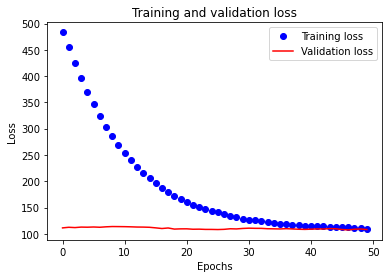

In [75]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

def plot_losses(history):
    loss_values = smooth_curve(history['train'])
    val_loss_values = smooth_curve(history['test'])
    epochs = np.arange(len(loss_values))
    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_losses(history)

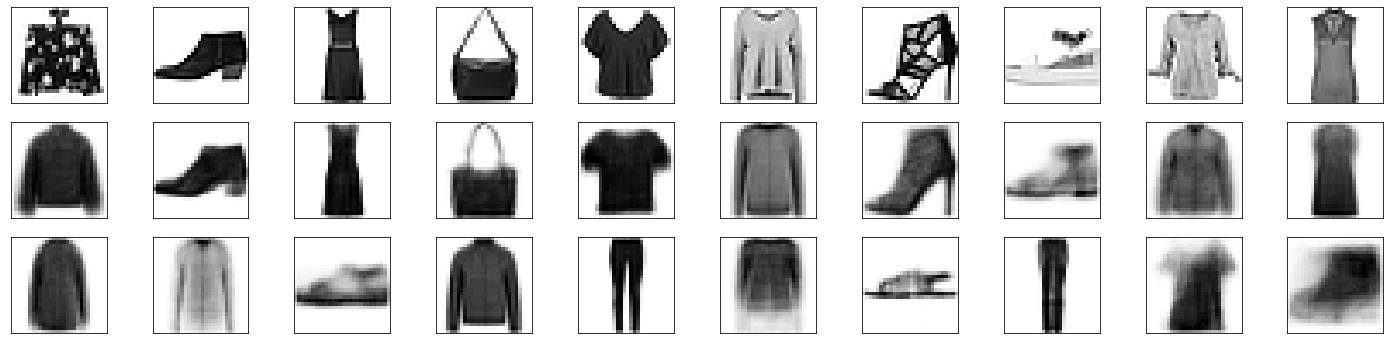

In [73]:
def example10(model, dataloader):
    dataiter = iter(dataloader)
    images, labels = dataiter.next()

    images_flatten = images.view(images.size(0), -1)
    _, __, recon = model(images_flatten)
    sample = torch.randn(10, model.hidden_dim)
    gen = model.decode(sample)

    images = images.numpy()[:10]
    recon = recon.view(batch_size, 1, 28, 28).detach().numpy()[:10]
    gen = gen.view(10, 1, 28, 28).detach().numpy()

    fig, axes = plt.subplots(nrows=3, ncols=10, sharex=True, sharey=True, figsize=(25,6))

    for images, row in zip([images, recon, gen], axes):
        for img, ax in zip(images, row):
            ax.imshow(np.squeeze(img), cmap='binary')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
example10(net2, testloader)

## Saving trained model

In [74]:
PATH = "pretrained/vae_with_hmc_fashionmnist.pth"
torch.save({
            'epoch': num_epochs,
            'model_state_dict': net2.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': history['train'],
            'test_loss': history['test'],
            }, PATH)